## Step 1)

Import the necessary packages.

In [159]:
# The import command allows us to call on various libraries
import folium
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import CRS
%matplotlib notebook

print('Packages Loaded')

Packages Loaded


## Step 2)

Read the data geocoded text file and covert it to a spatial data format.  This step is equivalent to "display xy data" in ArcGIS Pro.  Then we can quickly plot the data to make sure it imported properly.  We can also summarize and aggregate the tabular attributes in the data.

### Question 7)
What does looking at the demographics in this data tell you about police involved deaths in Canada?

<IPython.core.display.Javascript object>


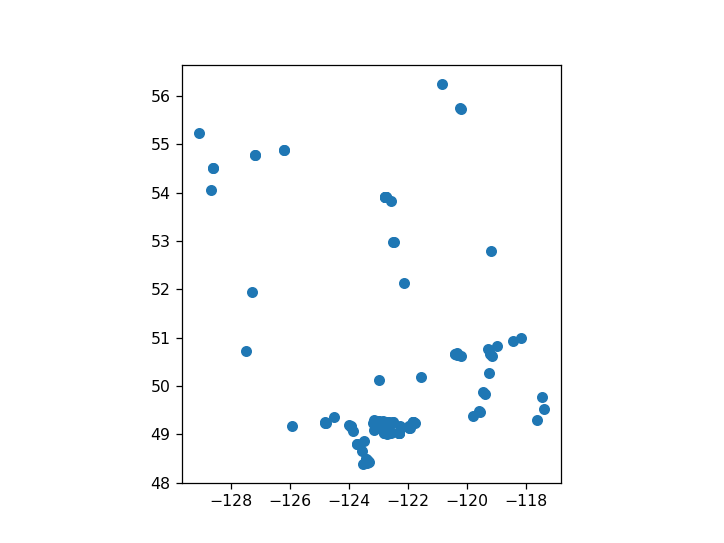

Demographics of Victims
gender          Female  Male  Unspecified
race                                     
Asian              NaN   4.0          NaN
Black              NaN   1.0          NaN
Indigenous         3.0  17.0          NaN
Latin American     2.0   2.0          NaN
Other              NaN   1.0          NaN
South Asian        NaN   4.0          NaN
Unspecified       11.0  66.0          3.0
White              2.0  31.0          NaN


In [160]:
BC_Data = pd.read_csv('Data/BC_Geocoded.csv',index_col='date',parse_dates=['date'])
BC_Data_dgf = gpd.GeoDataFrame(BC_Data,
    geometry=gpd.points_from_xy(BC_Data.longitude,
                                BC_Data.latitude,
                                crs=CRS("WGS84")
                               ))

BC_Data_dgf.plot()
print('Demographics of Victims')
print(BC_Data_dgf.groupby(['race','gender']).count()['id_victim'].unstack())

## Step 3)

Read the Census Subdivision shapefile.  Plot the BC population data to make sure it imported properly.  Zoom and pan to see what regions have the highest populations. "Uncomment" the last two lines in this block and re-run to make sure the point layer lines up with the polygon layer.

### Question 8)
Zoom to a region of interest and take a screenshot, showing both the points and polygon layer and submit it to canvas.

<IPython.core.display.Javascript object>


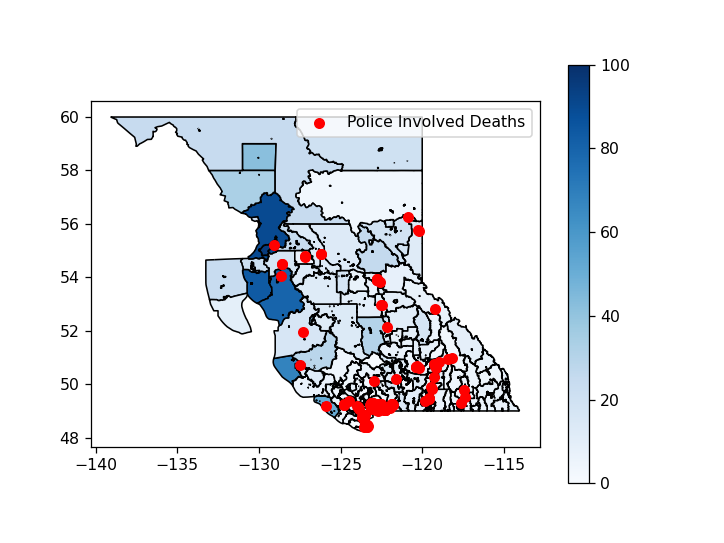

In [161]:
# the .read_file() function reads shapefiles
file_name='Data/CensusSubdivisions/SimplyAnalytics_Shapefiles_2021-06-05_04_38_29_83ea9514aaa369bc53410a64314ff38b.shp'
BC_csd = gpd.read_file(file_name)

BC_csd = BC_csd.rename(columns={
'VALUE0': '% Indigenous Identity',
'VALUE1': 'Population, 2016',
                    })
fig,ax=plt.subplots()
BC_csd.plot(ax=ax,column='% Indigenous Identity',cmap = 'Blues',edgecolor='black',legend=True)
BC_Data_dgf.plot(ax=ax,color='r',legend=True,label='Police Involved Deaths')
ax.legend()

## Step 4)

Loop through each row in the census subdivision layer.  Do a point in polygon vector overlay using the .within() function to find which incidents are in each polygon.  Add the total number of incidents for each subdivision as an attribute.

### Question 9)
What is the highest number of incidents in a single census subdivision?

<IPython.core.display.Javascript object>


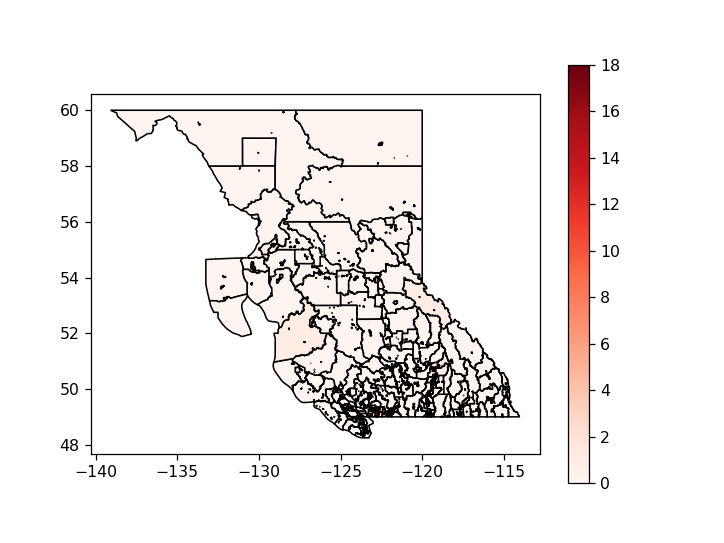

<AxesSubplot:>

In [150]:
BC_csd['Incidents'] = 0
for i,row in BC_csd.iterrows():
    pip = BC_Data_dgf.within(row['geometry'])
    if pip.sum()>0:
        BC_csd.loc[BC_csd.index==i,'Incidents']+=pip.sum()
BC_csd.plot(column='Incidents',cmap = 'Reds',edgecolor='black',legend=True)

## Step 5)

Normalize the data to calculate the police involved death rate.  Divide the number of incidents by the total population.  First do this for the whole province to calculate the provincial average.


### Question 10)
What is the provincial police involved death rate?
<!-- 2.88 -->

### Question 11)
What does this number mean?
<!-- For every million residents in BC, 2.88 people die from a police interaction per year -->

In [151]:
End_Year = BC_Data_dgf.index.year.max()
Start_Year = BC_Data_dgf.index.year.min()
Duration = End_Year-Start_Year
Unit = 1e6
Rate_conversion = Unit/Duration

Prov_rate = (BC_csd['Incidents'].sum()/BC_csd['Population, 2016'].sum()*Rate_conversion).round(2)
print('Province-Wide Police Involved Death Rate (June ',Start_Year,' - May ',End_Year,')')
print('per ', Unit,' Residents per year')
print(Prov_rate)

Province-Wide Police Involved Death Rate (June  2011  - May  2021 )
per  1000000.0  Residents per year
3.16


## Step 6)

Repeat the normalization process for the all census subdivisions.  Then select subdivisions with at least one incident and print the results.

### Question 12)
What is the general pattern you notice in regards to the relationship between the rate, number of incidents, and total population?  What explains this pattern?

In [152]:
BC_csd['PID_rate']=BC_csd['Incidents']/BC_csd['Population, 2016']*Rate_conversion
BC_csd_select = BC_csd.loc[BC_csd['PID_rate']>0]
BC_csd_select[['name','Population, 2016','Incidents','PID_rate','% Indigenous Identity']].sort_values(by='PID_rate')

,name,"Population, 2016",Incidents,PID_rate,% Indigenous Identity
145,"Richmond, BC (CSD)",198309.0,1,0.504264,0.8141
144,"Delta, BC (CSD)",102238.0,1,0.978110,2.6825
150,"Coquitlam, BC (CSD)",139284.0,2,1.435915,2.2383
452,"Kelowna, BC (CSD)",127380.0,2,1.570105,5.5126
140,"Langley (District municipality), BC (CSD)",117285.0,2,1.705248,3.7168
463,"Vernon, BC (CSD)",40116.0,1,2.492771,7.1789
87,"Mission, BC (CSD)",38833.0,1,2.575129,7.7826
148,"Burnaby, BC (CSD)",232755.0,6,2.577818,1.8242
147,"Vancouver, BC (CSD)",631486.0,17,2.692063,2.2500
149,"New Westminster, BC (CSD)",70996.0,2,2.817060,3.2772


## Step 7)

Select just the subdivisions with at least 10,000 residents and plot the relationship between % Indigenous Identity and the Police-Involved Death Rate.  Fix the title so it says the correct years (2011-2021).  Then download the plot and submit it to canvas.  
<a href="Content/Download.mp4" target="_blank">See this video instructions for help downloading the plot</a>


Notice the outlier on the plot.  The value in Kent, BC (CSD) is more than double the next highest value. That is because the data from the Georgia Straight includes dearths in prison, and there is a prison in Agassiz, which is in this CSC.

### Question 13)

Submit the plot to canvas.

<IPython.core.display.Javascript object>


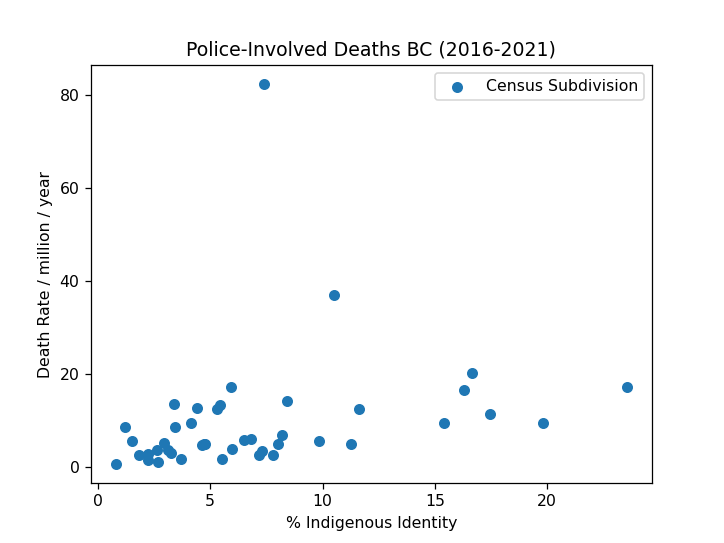

In [157]:
plt.figure()
BC_csd_select=BC_csd_select.loc[(BC_csd_select['Population, 2016']>5000)]
legend_entry='Census Subdivision'
plt.scatter(BC_csd_select['% Indigenous Identity'],BC_csd_select['PID_rate'],label=legend_entry)
plt.xlabel('% Indigenous Identity')
plt.ylabel('Death Rate / million / year')
plt.title('Police-Involved Deaths BC (2016-2021)')
plt.legend()
plt.savefig('Scatterplot_Indidents_Indigenous_Identity.png')

## Step 8)

Plot the selection as a choropleth map.  

### Question 14)

Where are the census subdivisons over 10,000 residents with the highst police involved death rates?  What does this tell us about the urban-rural dichotomy?  Do you think this issue would get more attention if Vanocouver or Victoria had a police involved death rate simlar to 

In [158]:
# Create a webmap centered on BC at zoom level 5 with the default basemap   
Map = folium.Map(location=[52, -125],zoom_start=6)
BC_csd_select.to_file("Data/BC_csd_select.json", driver = "GeoJSON")
folium.features.Choropleth('Data/BC_csd_select.json',
                           # It will match the geometry data up with a pandas or geopandas dataframe
                            data=BC_csd_select,
                            columns=['spatial_id','PID_rate'],
                           # They key in the GeoJSON file to match by
                            key_on='feature.properties.spatial_id',
                            bins = [0,1,10,25,50,83],
                            fill_color='PuRd',
                            fill_opacity = 1,
                            smooth=2,
                           # The legend label
                            legend_name='Population, 2016'
                          ).add_to(Map)
Map